# **Parkinson Severity Classification: Audio Processing**

## **Objective**

The objective of this project is to implement an automatic system for **the determination of the severity level of  Parkinson's Disease (PD) of a patient by using speech features**. This system takes a speech utterance from an unknown speaker and provides their level of PD by analyzing their voice by means of machine learning techniques.

Patients with PD usually have difficulties in speaking because of reduced coordination of the muscles involved in the human speech production system. This causes distortions in the phoneme articulation, prosody, etc., diminishing the subject's speech intelligibility.


We have tried two main approaches along this project, one based on **speech features of fixed length** and another in **time-varying speech features (sequences of features)**.

In the both approaches we have considered different models, and in the first one several feature extraction methods. Then we have selected the best alternative overall, in terms of predictive performance.

The ***models*** considered are the following:

- In the approach based on **speech features of fixed length**: 

   - **Random Forest (RF)**
   - **Extreme Gradient Boosting (XGBoost)**
   - **Multi-layer Perceptron (MLP)**
   - Two **Neural Networks** implemented by mean of `PyTorch` 

- In the approach based on  **time-varying speech features (sequences of features)**:

  - **Gaussian Mixture Models (GMM)**
  - **Recurrent Neural Networks (RNN)**  implemented in `PyTorch`


And the ***feature extraction methods*** are the next ones:

- **Mel-Frequency Cepstrum Coefficients (MFCC)**
- **Chromagram**
- **Spectral Centroid**
- **Spectral Bandwith**
- **Spectral Contrast** 
- **Spectral Rolloff**
- **Zero Crossing Rate**
- **Tempogram**

## **Requirements**

In [5]:
import numpy  as np
import polars as pl
import sys
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
import IPython.display as ipd
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private")
from PyAudio.preprocessing import get_X_audio_features, get_X_tensor_audio_features

## **Data**

We have a database composed by the following elements:

- **20 speakers** 

- **12 audios per speaker**

- We have speakers with different Parkinson disease levels:

    - **normal (0)** 
    - **slight (1)**
    - **moderate (2)**
    - **severe (3)**
    
    hat has been recorded at a **sampling frequency of 16000 Hz**.

The dataset has been manually annotated following a subset of the **Unified Parkinson’s Disease Rating Scale (UPDRS)**, a scoring scale utilized by neurologistics for clinical assessment of PD.



## **Reading Speech Files**

In this section we are going to show how to read speech files by mean od `librosa`.

### **Reading a class 0 (normal) speech**

Here we read a normal (0) speech.

In [7]:
# Reading a speech file from the database - Class 0

fs = 16000  # sampling frequency
audio_file = 'PDSpeechData/loc17/loc17_s01.wav'  # speech file

# 'audio_signal_1' is an array with the amplitude of the audio signal along the time:
audio_signal_1, sr = librosa.load(audio_file, sr=fs)

We have set a sampling frequency of 16000, this means that for each second we have 16000 values of amplitude. The time length of the read audio file is 13 seconds, so we have  approximately  13*16000 = 208000 points of amplitude. This amplitudes point are saved in the array `audio_signal_1`.


Each audio file contains the amplitude of the audio expressed in a continuous scale, and what `librosa.load(audio_file, sr=fs)` does is to extract fs (16000) points for each 1 second interval of amplitudes of the original file. Each 1 sec interval is a continues interval, therefore, with infinity values, and the algorithm selects 16000 samples equally spaced.

In [8]:
audio_signal_1

array([ 0.04125977,  0.05276489,  0.03128052, ..., -0.00030518,
       -0.00030518, -0.00033569], dtype=float32)

In [9]:
time_audio_signal_1 = 13
time_audio_signal_1 * fs

208000

In [10]:
audio_signal_1.shape

(216500,)

- Plotting the audio signal amplitudes along time

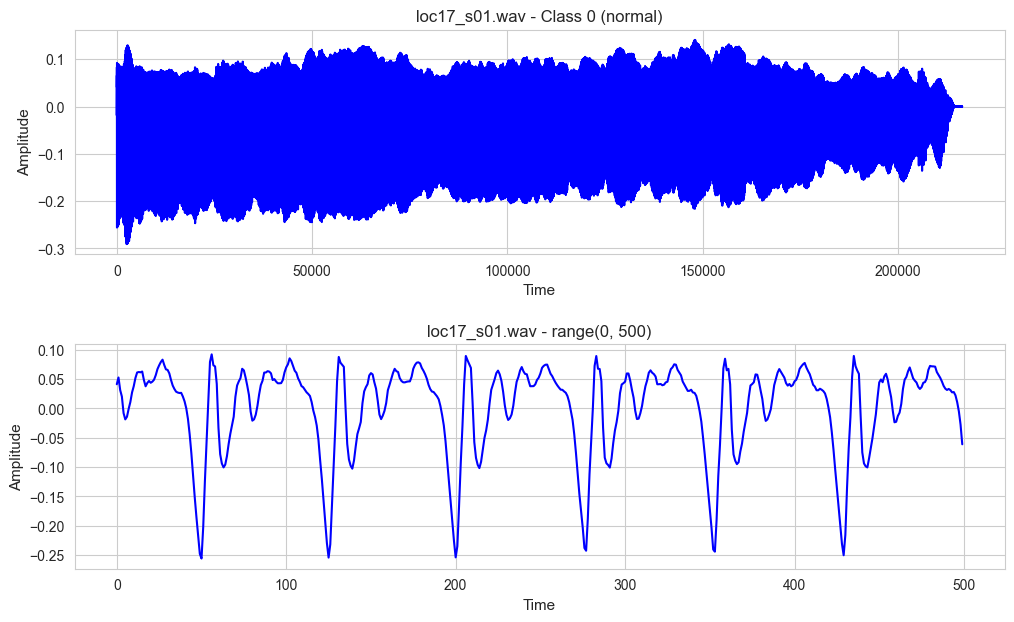

In [11]:
audio_signal = audio_signal_1
filter = range(0,500)
fig, axes = plt.subplots(2, 1, figsize=(12,7))
axes = axes.flatten()  

sns.lineplot(y=audio_signal, x=range(len(audio_signal)), color='blue', ax=axes[0])
sns.lineplot(y=audio_signal[filter], x=filter, color='blue', ax=axes[1])

axes[0].set_title(audio_file.split('/')[-1] + ' - Class 0 (normal)')
axes[1].set_title(audio_file.split('/')[-1] + f' - {str(filter)}')

for i in range(len(axes)):
    axes[i].set_ylabel('Amplitude', size=11)
    axes[i].set_xlabel('Time', size=11)
plt.subplots_adjust(hspace=0.4, wspace=0.5) 

- Displaying the audio file as sound:

In [12]:
ipd.Audio(audio_signal_1, rate=fs)

### **Reading a class 3 (severe) speech**

Now we read a severe (3) speech.

In [13]:
# Reading a speech file from the database - Class 3

fs = 16000  # sampling frequency
audio_file = 'PDSpeechData/loc18/loc18_s01.wav'  # speech file

audio_signal_2, sr = librosa.load(audio_file, sr=fs)
# 'audio_signal_2' is an array with the amplitude of the audio signal along the time

In [14]:
audio_signal_2

array([-0.25128174, -0.37490845, -0.24560547, ..., -0.04568481,
       -0.04675293, -0.04760742], dtype=float32)

In [15]:
time_audio_signal_2 = 7
time_audio_signal_2 * fs

112000

In [16]:
audio_signal_2.shape

(122500,)

- Plotting the audio signal amplitudes along time

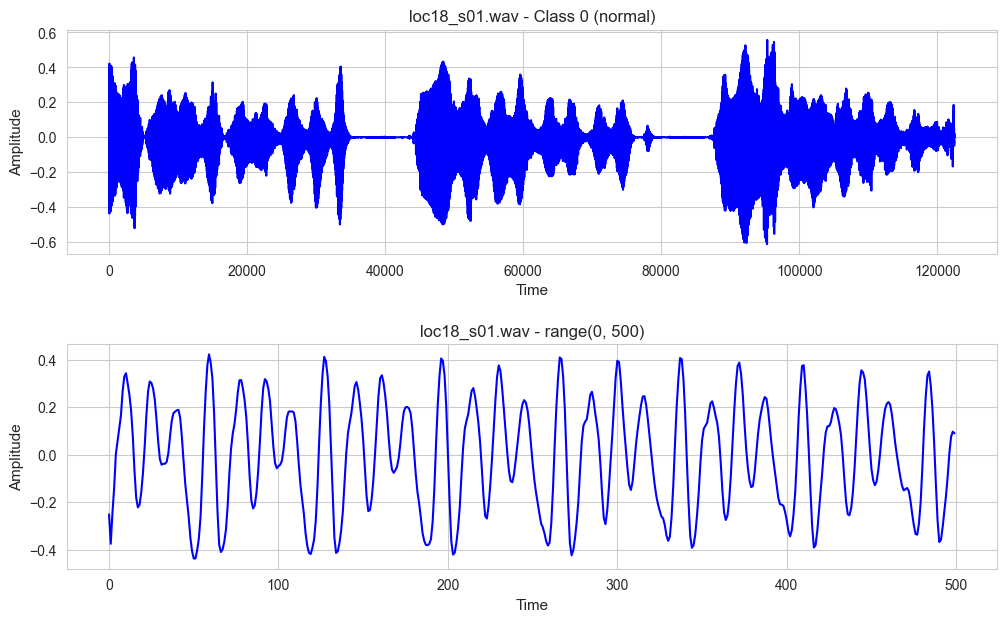

In [17]:
audio_signal = audio_signal_2
filter = range(0,500)
fig, axes = plt.subplots(2, 1, figsize=(12,7))
axes = axes.flatten()  

sns.lineplot(y=audio_signal, x=range(len(audio_signal)), color='blue', ax=axes[0])
sns.lineplot(y=audio_signal[filter], x=filter, color='blue', ax=axes[1])

axes[0].set_title(audio_file.split('/')[-1] + ' - Class 0 (normal)')
axes[1].set_title(audio_file.split('/')[-1] + f' - {str(filter)}')

for i in range(len(axes)):
    axes[i].set_ylabel('Amplitude', size=11)
    axes[i].set_xlabel('Time', size=11)
plt.subplots_adjust(hspace=0.4, wspace=0.5) 

- Displaying the audio file as sound:

In [18]:
# Play the audio data
ipd.Audio(audio_signal_2, rate=fs)

## **Feature extraction**

In the following section we show an example of feature extraction for the previous speech signal `audio_signal_2`.



The point is, given an audio signal, extract features that characterize it, to be used along with Machine Learning algorithms, in this case to classify a new signal in one of the four PD levels mentioned above.

We distinguish two types of audio features:

- T**ime-varying features (sequencies)**

   - This type are suitable to be used with models that work well with sequential data, like Recurrent Neural Networks and Gaussian Mixture Models.

- **Fix length features**

  - This type is suitable  for models that work with tabular data, like Random Forest, XGBoost and Multi-Layer Perceptron Neural Networks.

  - This features are basically statistics computed on the  time-varying features.

The methods for features extraction that we are going to use along this projects are the following:

- Mel-Frequency Cepstrum Coefficients (MFCC)
- Chromagram
- Spectral Centroid
- Spectral Bandwith
- Spectral Contrast 
Spectral Rolloff
- Zero Crossing Rate
- Tempogram

These methods are applied directly to the amplitudes series of a given audio signal and return a matrix with the time-varying features for that signal. Then, we can retrieve a vector with the statistic about the features of that matrix, these will be the fixed length features of that audio signal.

This process can be done for all the $n$ available audio signals, then we obtain $n$ matrices with time-varying features.

Then, this $n$ matrices can be accommodated in a 3D array, also known as **tensor**, that can be used as input by different Machine Learning, typically deep learning algorithms, like Recurrent Neural Networks (RNN).

But these $n$ matrices (2D arrays) can also be transformed in vectors (1D arrays) computing statistics like mean or standard deviation for the features contained in those matrices. Then, we have $n$ 1D arrays that can be concatenated to build a 2D array that could be interpreted as a **predictor matrix** (tabular data) to be used as input by classic Machine Learning algorithms, that work well with tabular data.


### **Mel-Frequency Cepstrum Coefficients (MFCC)**

MFCCs are a feature representation that captures the power spectrum of an audio signal, using a cosine transform of a log power spectrum on a nonlinear Mel scale of frequency. This Mel scale aims to mimic the human ear's response more closely than the linearly-spaced frequency bands used in the typical Fourier transform. This makes MFCCs particularly useful for applications like speech recognition or music analysis, where the perception-like representation of audio can be more beneficial than purely physical representations.

The MFCC components refer to the number of coefficients extracted from each frame of the audio signal. The choice of the number of components is somewhat arbitrary but is based on empirical evidence suggesting that the first few coefficients (usually the first 12 to 20) capture most of the useful information about the spectral envelope of the audio signal. The higher coefficients, which represent finer details of the spectrum, are often discarded.


In this case, we want to compute a sequence of Mel-Frequency Cepstrum Coefficients (MFCC) with the following configuration:

- **Size of the analysis window = 32 ms = 0.032 secs**

- **Frame period or hop length = 8 ms = 0.008 secs**

- **Number of filters in the mel filterbank = 40**

- **Number of MFCC components = 20**

For doing that, we are going to use the function `mfcc` from the module *feature* of the `librosa` package. This function has, among others, the following input arguments:

* `y`: speech signal
* `sr`: sampling frequency
* `n_fft`: window size (in samples)
* `hop_length`: frame period or hop length (in samples)
* `n_mels`: number of filters in the mel filterbank
* `n_mfcc`: number of MFCC components

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (fs) indicates that 1 second corresponds to fs samples (in our case, as fs=16000 Hz, 1 second corresponds to 16000 samples), the conversion from **seconds** to **samples** is performed by:

```
samples = seconds*fs = seconds*16000
```

In [19]:
# Specifying variables for feature extraction
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In [16]:
# Feature extraction with MFCC 
x_MFCC = librosa.feature.mfcc(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

In [17]:
x_MFCC

array([[-1.5723482e+02,  8.1401794e+01, -1.0822573e+01, ...,
        -1.4883176e+00, -2.3103115e-01, -5.7656441e+00],
       [-1.4987587e+02,  8.2267227e+01, -1.5025454e+01, ...,
        -4.9614630e+00, -5.0628245e-01, -1.0207132e+01],
       [-1.5724088e+02,  7.8481644e+01, -2.0651829e+01, ...,
        -8.5300264e+00, -1.4817656e+00, -1.2810444e+01],
       ...,
       [-4.8450891e+02,  1.6448849e+01,  1.2042265e+01, ...,
         1.0532631e+00,  6.7879003e-01,  3.1149516e-01],
       [-4.8156741e+02,  2.0192478e+01,  1.4441982e+01, ...,
         8.4327966e-01, -4.1927201e-01,  1.3737071e-01],
       [-4.7447165e+02,  2.9626501e+01,  2.1557457e+01, ...,
         5.4327607e-01, -3.4168136e-01, -1.5610456e-01]], dtype=float32)

In [18]:
x_MFCC.shape

(1692, 20)

`x_MFCC` is a `time-samples x ncomp = 1692 x 20` matrix, where its columns represent features and its rows observations.

- `20` is the number of Mel-Frequency Cepstrum Coefficients (MFCC) components, and is defined apriori as a hyper-parameter.

- `1692` is the number of time-samples fort that audio signal, and is defined as the number of samples of the audio signal divided between the frame period (in samples).


In [19]:
ncomp

20

In [20]:
n_samples_audio_signal_1 = len(audio_signal_1)
time_samples_audio_signal_1 = np.ceil(n_samples_audio_signal_1 / fp)
time_samples_audio_signal_1

1692.0

The columns of `x_MFCC`, which are the MFCC components could be interpreted as features of the audio signal, and its rows as the value of these features along time, and this is why we called these features as 'time-varying' features.

It's important to realize that `x_MFCC` is the MFCC matrix for one single audio signal, concretely for `audio_signal_1`.

But we want to obtain this matrix for the available data, let say, for all the available audio signals, in order to build a tensor or a predictors matrix to be used along with Machine Learning models, to carry out the classification task of this project, which is our main goal.

#### **From MFCC matrices to tensor** 

The task is to transform the $n$ MFCC matrices (one per audio) into a tensor (3D array) of shape `n x ncomp x max-n_time_samples`. 

For doing that we are going to use our custom function `get_X_tensor_audio_features`, that takes a list of audio file paths, a method for features extraction  and the parameters for that method, then process the audio files as signals, and apply the specified feature extraction method on the signal, obtaining **time-varying features** of it. 

This process is repeated for each audio file, obtaining $n$ MFCC matrices of size `ncomp x max-n_time_samples`, and the results are allocated in a 3D array of size `n x ncomp x max-n_time_samples`, that is, in a tensor of size. The final output of out function is the desired tensor.

Later is explained why the las dimension of the tensor is `max-n_time_samples`.

We read all the audio file paths along with their belonging class, and accommodate them in a data-frame.

In [21]:
files_list_name = 'Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

In [22]:
files_df.head(3)

path,level
str,i64
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0


We have 240 audio files.

In [23]:
files_df.shape

(240, 2)

Now we can process all those audio files, extract time-varying features form them and build a tensor to be used in ML models like RNN.

In this case we are using MFCC as features extraction method, with the parameters defined previously.

In [24]:
X_MFCC_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='MFCC', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

As you can see this is indeed a tensor, since it is a 3D array with shape `(240, 20, 4403)`.

This means that for each one of our 240 audios, we have a MFCC matrix, with time-varying features that characterize it.

In [25]:
X_MFCC_tensor

array([[[-3.25005737e+02, -3.13607208e+02, -3.10144470e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.67731781e+01,  7.59160614e+01,  7.93242340e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.46149426e+01,  1.50402470e+01,  1.77627831e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.79171467e+00, -1.09497318e+01, -9.35082436e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.61563778e+00, -1.05655603e+01, -6.97648907e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.39404225e-01, -1.94986522e+00,  3.36962867e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.77771057e+02, -3.72950775e+02, -3.70798340e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.37817211e+01,  1.93036613e+01,  2.15146694e+01, ...,
          0.00000000e+00,  0.00000000e

In [26]:
X_MFCC_tensor.shape

(240, 20, 4403)

For example, this is the MFCC matrix for our first audio file:

In [27]:
X_MFCC_tensor[0]

array([[-325.0057373 , -313.60720825, -310.14447021, ...,    0.        ,
           0.        ,    0.        ],
       [  66.7731781 ,   75.9160614 ,   79.32423401, ...,    0.        ,
           0.        ,    0.        ],
       [  14.61494255,   15.04024696,   17.76278305, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [  -4.79171467,  -10.94973183,   -9.35082436, ...,    0.        ,
           0.        ,    0.        ],
       [  -3.61563778,  -10.56556034,   -6.97648907, ...,    0.        ,
           0.        ,    0.        ],
       [   0.83940423,   -1.94986522,    3.36962867, ...,    0.        ,
           0.        ,    0.        ]])

In [28]:
X_MFCC_tensor[0].shape

(20, 4403)

As you can see there are zeros at the end of each row, this are the results of padding the MFCC matrix.

The point is that each audio has a different size MFCC matrix (in time-samples terms, since all of them have the same number of components), so, in order to allocate all of them in a 3D array we need to enforce the same size for all of them, and this is done by forcing all the MFCC to have the same number of time-samples, concretely the maximum one `(max-n_time_samples)`, let say, the one of the largest MFCC matrix. So, now all the MFCC matrices will have extra positions in the time-samples (except the largest one), and those extra positions   are filled with zeros. This process is called as padding, and is done automatically by our function `get_X_tensor_audio_features`.

#### **From MFCC matrices to predictors matrix (tabular data)**

The task is to transform the $n$ MFCC matrices (one per audio) into a predictors matrix (2D array) of shape `n x ncomp`. 

For doing this we are going to use aur custom function `get_X_audio_features`, that takes a list of audio file paths, a method for features extraction  and the parameters for that method, then process the audio files as signals, and apply the specified feature extraction method on the signal, obtaining **time-varying features** of it. Then **statistics** are computed for each feature along the time dimension, obtaining a vector (1D array) of size `ncomp`.

This process is repeated for each audio file, obtaining $n$ vectors, and the results are allocated in a 2D array of size `n x ncomp`, that is, a matrix. The final output of our function is the desired predictors matrix.

Here, as example, we compute two possible predictors (features) matrices using the MFCC method for feature extraction and two different statistics configurations, one with the mean and another with both the  mean and the standard deviation.

In [29]:
X_MFCC_stats_1 = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)
X_MFCC_stats_2 = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

These matrices has predictors as columns and observations/samples as rows. 

Since we are working with 240 audios these matrices will have 240 rows, and the number of predictors depends on the used statistics. 

If only one statistic us used, as in the first case, we will have a number of predictors equal to the number of components fixed for the features extraction method, in this case 20.

If we use a combination of several statistics, let say $k$, the number of predictors will be `k*ncomp`. 

In the first case, since we have used only the mean as statistics the number of predictors is equal to the number of MFCC components, so 20. These predictors represent the mean of the time-varying components for each audio. For example, the first predictors contains the mean of the first time-varying MFCC component (the mean of that component along time) for each one of the 240 available audios.

In the second case we have used two statistics, therefore the number of predictors is 40 (2*20), the first 20 predictors represent the mean of the 20 time-varying components for each audio file, and the next 20 predictors represent the standard deviation.

Is pretty obvious that this idea can be generalized, so, we can use any combination of statistics as well as of features extraction to build predictors matrices to be used along with ML algorithms in predictive scenarios like this. 

In the predictive part of this project we will explore these alternatives, both combining different statistics as well as features extraction methods.

***Note:*** when we talk about combining feature extraction methods what we mean is to obtain 
 matrices using different methods and then concatenate them to form a single predictors matrix that combines the information of them, which could improve the predictive performance of certain models.  This option  has been considered in the predictive part.

In [30]:
X_MFCC_stats_1

array([[-2.13158752e+02,  9.29840240e+01, -6.40546494e+01, ...,
        -2.17615294e+00,  2.29761638e-02, -5.47736108e-01],
       [-1.98984543e+02,  6.80483322e+01, -4.74277916e+01, ...,
         4.45366669e+00,  9.83190179e-01, -4.84144878e+00],
       [-2.40027390e+02,  5.97654343e+01, -2.60434890e+00, ...,
         7.12371826e-01, -3.60437250e+00, -7.20492887e+00],
       ...,
       [-2.91605225e+02,  8.18440247e+01,  2.95778332e+01, ...,
         1.58350534e+01,  1.41482115e+01,  1.16930342e+01],
       [-2.12697678e+02,  7.87770691e+01,  1.69434319e+01, ...,
        -4.82905912e+00,  2.94541955e+00,  1.33842838e+00],
       [-2.09183228e+02,  7.25918579e+01,  3.24228172e+01, ...,
        -1.01590958e+01,  1.20261431e+00, -3.76960754e+00]], dtype=float32)

In [31]:
X_MFCC_stats_1.shape

(240, 20)

In [32]:
X_MFCC_stats_2

array([[-213.15875  ,   92.984024 ,  -64.05465  , ...,    7.095715 ,
           6.177743 ,    5.351471 ],
       [-198.98454  ,   68.04833  ,  -47.42779  , ...,    6.012935 ,
           5.59839  ,    4.8842993],
       [-240.02739  ,   59.765434 ,   -2.604349 , ...,    5.646291 ,
           5.4601407,    6.5454264],
       ...,
       [-291.60522  ,   81.844025 ,   29.577833 , ...,   13.644189 ,
          11.3029785,    9.850929 ],
       [-212.69768  ,   78.77707  ,   16.943432 , ...,    2.2818298,
           2.13314  ,    2.4295764],
       [-209.18323  ,   72.59186  ,   32.422817 , ...,    2.3896735,
           3.0300555,    2.1277957]], dtype=float32)

In [33]:
X_MFCC_stats_2.shape

(240, 40)

#### **Example of predictors matrix that combines different features extraction methods and statistics**

In [34]:
X_MFCC_stats = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)
X_chroma_stats = get_X_audio_features(paths=files_df['path'], method='chroma', stats='median-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

In [35]:
X_MFCC_stats.shape

(240, 40)

In [36]:
X_chroma_stats.shape

(240, 24)

In [37]:
X_combined = np.concatenate((X_MFCC_stats, X_chroma_stats), axis=1)
X_combined

array([[-2.1315875e+02,  9.2984024e+01, -6.4054649e+01, ...,
         2.7830657e-01,  3.4890896e-01,  1.7714919e-01],
       [-1.9898454e+02,  6.8048332e+01, -4.7427792e+01, ...,
         3.7769288e-01,  1.5670222e-01,  2.0125444e-01],
       [-2.4002739e+02,  5.9765434e+01, -2.6043489e+00, ...,
         1.8112896e-01,  2.1978563e-01,  3.3394688e-01],
       ...,
       [-2.9160522e+02,  8.1844025e+01,  2.9577833e+01, ...,
         3.7720391e-01,  3.9648506e-01,  4.0834939e-01],
       [-2.1269768e+02,  7.8777069e+01,  1.6943432e+01, ...,
         4.0676277e-02,  7.6654352e-02,  9.9300966e-02],
       [-2.0918323e+02,  7.2591858e+01,  3.2422817e+01, ...,
         2.8915258e-02,  3.2900050e-02,  3.4263603e-02]], dtype=float32)

In [38]:
X_combined.shape

(240, 64)

### **Chromagram**

Chroma features are a powerful tool for analyzing music. They capture the essence of harmony, melody, and tonality of musical signals. By projecting the entire spectrum onto 12 different bins representing the 12 distinct semitones (or chromatic scale) in Western music, chroma features provide a high-level representation of music or audio in terms of octaves. This can be particularly useful for capturing the musical aspects of speech which could correlate with disease states.


In [39]:
# Feature extraction with Chromagram 
x_chroma = librosa.feature.chroma_stft(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [40]:
x_chroma

array([[0.76920897, 0.776894  , 0.34586996, ..., 1.        , 0.63658094,
        0.48888198],
       [0.5365836 , 0.57130456, 0.07953023, ..., 1.        , 0.46217796,
        0.23196535],
       [0.59507215, 0.52440584, 0.04829044, ..., 1.        , 0.4172734 ,
        0.19030185],
       ...,
       [0.9172087 , 0.7431331 , 0.6895156 , ..., 0.8187049 , 0.9443104 ,
        1.        ],
       [0.9935548 , 0.934088  , 0.8525207 , ..., 0.9157632 , 0.99230087,
        1.        ],
       [0.93939584, 1.        , 0.96149266, ..., 0.8938448 , 0.92480946,
        0.94353443]], dtype=float32)

In [41]:
x_chroma.shape

(1692, 12)

#### **From Chroma matrices to tensor** 

In [42]:
X_chroma_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='chroma', sr=fs, n_fft=nfft, hop_length=fp)

In [43]:
X_chroma_tensor

array([[[3.30834001e-01, 2.73084641e-01, 1.72916576e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.88729805e-01, 3.64229351e-01, 3.07732373e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.24708462e-01, 8.15815687e-01, 7.72476017e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [7.54282296e-01, 9.33874607e-01, 6.54246688e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.48958814e-01, 5.71549773e-01, 4.18673873e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.12655747e-01, 3.80960107e-01, 2.34689996e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.12040150e-01, 1.55773565e-01, 2.85095990e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.72878194e-01, 2.47185424e-01, 3.49979341e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.39971995e-01, 

In [44]:
X_chroma_tensor.shape

(240, 12, 4403)

#### **From Chroma matrices to predictors matrix (tabular data)**

In [45]:
X_chroma_stats = get_X_audio_features(paths=files_df['path'], method='chroma', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [46]:
X_chroma_stats

array([[0.32919034, 0.48674947, 0.13121736, ..., 0.27830657, 0.34890896,
        0.17714919],
       [0.11371233, 0.19766188, 0.09701521, ..., 0.37769288, 0.15670222,
        0.20125444],
       [0.5519331 , 0.1438093 , 0.08654997, ..., 0.18112896, 0.21978563,
        0.33394688],
       ...,
       [0.25067928, 0.23875663, 0.26547787, ..., 0.3772039 , 0.39648506,
        0.4083494 ],
       [0.3393735 , 0.5189489 , 0.7807806 , ..., 0.04067628, 0.07665435,
        0.09930097],
       [0.30499187, 0.47429892, 0.7501884 , ..., 0.02891526, 0.03290005,
        0.0342636 ]], dtype=float32)

In [47]:
X_chroma_stats.shape

(240, 24)

### **Spectral Centroid**

The Spectral Centroid represents the center of mass of the spectrum, providing a measure of the brightness of a sound. It is calculated as the weighted mean of the frequencies present in the sound, with their magnitudes as the weights. This feature gives an idea of how high or low the majority of the energy is in a sound spectrum.


In [48]:
# Feature extraction with spectral centroid 
x_spectral_centroid = librosa.feature.spectral_centroid(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [49]:
x_spectral_centroid

array([[1173.49156085],
       [1173.44240948],
       [1225.6018241 ],
       ...,
       [2030.97788411],
       [2028.13073426],
       [1640.92396239]])

In [50]:
x_spectral_centroid.shape

(1692, 1)

#### **From Spectral Centroid matrices to tensor** 

In [51]:
X_spectral_centroid_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_centroid', sr=fs, n_fft=nfft, hop_length=fp)

In [52]:
X_spectral_centroid_tensor

array([[[ 860.68242317,  737.32612638,  702.74733212, ...,
            0.        ,    0.        ,    0.        ]],

       [[1722.98555129, 1677.03902985, 1615.59102764, ...,
            0.        ,    0.        ,    0.        ]],

       [[1479.32504338, 1345.68771268, 1360.28338621, ...,
            0.        ,    0.        ,    0.        ]],

       ...,

       [[ 663.09360913,  586.61483978,  520.02672314, ...,
            0.        ,    0.        ,    0.        ]],

       [[1086.38030366,  971.71842423,  898.1939858 , ...,
            0.        ,    0.        ,    0.        ]],

       [[ 796.84943399,  704.26379079,  679.87846212, ...,
            0.        ,    0.        ,    0.        ]]])

In [53]:
X_spectral_centroid_tensor.shape

(240, 1, 4403)

#### **From Spectral Centroid matrices to predictors matrix** 

In [54]:
X_spectral_centroid_stats = get_X_audio_features(paths=files_df['path'], method='spectral_centroid', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [55]:
X_spectral_centroid_stats

array([[1222.51022012,  106.02869666],
       [1352.95675704,  292.90811358],
       [1573.29651356,  452.12319515],
       [1148.70689305,  102.08901252],
       [1030.46170316,  187.55238243],
       [1295.44084773,  208.27129492],
       [1263.05181668,  248.44794161],
       [1003.50312509,  133.57028631],
       [1070.73699491,  129.43194965],
       [1069.19199417,  149.36018421],
       [ 770.5005775 ,   59.60935519],
       [ 453.24031129,   29.71792047],
       [1344.7035196 ,  725.68509036],
       [1336.46868934,  608.80623466],
       [1227.09023004,  106.67904364],
       [1434.53104501,  117.39653373],
       [1932.02713538,  170.23029854],
       [ 932.59136027,  124.93733827],
       [ 696.62066277,  276.71068651],
       [1963.60256868,  720.26894443],
       [1915.64251365,  665.98189964],
       [ 919.65891344,  431.09062568],
       [1187.01412327,  447.66393129],
       [1199.32941239,  480.20315422],
       [ 852.61529121,  514.50788938],
       [ 546.81791865,  5

In [56]:
X_spectral_centroid_stats.shape

(240, 2)

### **Spectral Bandwidth**

Spectral Bandwidth measures the width of a band of frequencies and is defined as the width of the range of frequencies at which the magnitude of the spectrum is greater than a certain percentage of the peak magnitude. It reflects the spread of the spectrum and can indicate the complexity of a sound. A wider bandwidth signifies a noise-like or complex sound, while a narrow bandwidth indicates a tonal or simple sound.


In [57]:
# Feature extraction with spectral bandwith 
x_spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [58]:
x_spectral_bandwidth

array([[1309.30089921],
       [1255.1158018 ],
       [1275.03885178],
       ...,
       [2427.90186889],
       [2420.073342  ],
       [2256.56008742]])

In [59]:
x_spectral_bandwidth.shape

(1692, 1)

#### **From Spectral Bandwidth matrices to tensor** 

In [60]:
X_spectral_bandwidth_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_bandwidth', sr=fs, n_fft=nfft, hop_length=fp)

In [61]:
X_spectral_bandwidth_tensor

array([[[1143.32497568,  942.13602371,  870.97126742, ...,
            0.        ,    0.        ,    0.        ]],

       [[1785.06408858, 1760.67818379, 1734.84937353, ...,
            0.        ,    0.        ,    0.        ]],

       [[1574.27623182, 1486.74798403, 1545.91856   , ...,
            0.        ,    0.        ,    0.        ]],

       ...,

       [[ 901.28159703,  722.00737352,  537.66098854, ...,
            0.        ,    0.        ,    0.        ]],

       [[1617.36931068, 1553.21232249, 1469.45092787, ...,
            0.        ,    0.        ,    0.        ]],

       [[1417.14548475, 1323.33541644, 1265.27486656, ...,
            0.        ,    0.        ,    0.        ]]])

In [62]:
X_spectral_bandwidth_tensor.shape

(240, 1, 4403)

#### **From Spectral Bandwidth matrices to predictors matrix (tabular data)**

In [63]:
X_spectral_bandwidth_stats = get_X_audio_features(paths=files_df['path'], method='spectral_bandwidth', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [64]:
X_spectral_bandwidth_stats

array([[ 547.71039463,  190.68833226],
       [ 949.60789304,  210.65348963],
       [1257.37962494,  221.11233883],
       [ 655.10901947,  266.61427025],
       [1036.72287665,  183.3495748 ],
       [1087.49948991,  499.1671853 ],
       [1112.26886734,  453.83392324],
       [1008.52278684,  169.65089348],
       [1136.31978971,  114.58698542],
       [1369.45105255,  137.89868859],
       [ 733.60358082,   90.93676414],
       [ 600.8755911 ,   55.60126607],
       [1797.74599018,  734.56558902],
       [1776.10775885,  612.33648523],
       [ 944.46518321,  149.55301631],
       [1434.2496765 ,  105.46849527],
       [1954.60189389,  100.56700799],
       [ 910.6004008 ,  154.15121229],
       [ 765.39650212,  290.37160189],
       [1983.59218098,  620.01437049],
       [1981.69727227,  581.72095076],
       [ 998.51875333,  408.45410957],
       [1450.18425688,  454.85092884],
       [1518.25136553,  482.11063008],
       [1094.91762071,  458.69315579],
       [ 781.96866483,  4

In [65]:
X_spectral_bandwidth_stats.shape

(240, 2)

### **Spectral Contrast**

Spectral Contrast considers the difference in amplitude between peaks and valleys in the spectrum. This feature can be used to distinguish between different types of sound textures and timbres, as it effectively captures the dynamics of the spectral peaks and troughs over time.


In [66]:
# Feature extraction with Spectral Contrast 
x_spectral_contrast = librosa.feature.spectral_contrast(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [67]:
x_spectral_contrast

array([[ 5.63810593,  5.66707538,  6.30149297, ..., 13.96765089,
        12.25343919, 10.17588324],
       [ 6.21691956, 11.38575072, 11.8819769 , ..., 21.75429392,
        18.58376962, 15.36240143],
       [25.49436508, 18.267316  , 25.67031318, ..., 19.25143146,
        17.4834322 , 15.83951655],
       ...,
       [ 9.64391107,  3.7931424 , 10.92962245, ..., 17.23052401,
        15.0653737 , 11.47613243],
       [11.83635255, 10.54209236,  8.97554807, ..., 17.5021864 ,
        10.951186  , 12.79228362],
       [ 8.21206286,  2.71809055,  4.90784151, ..., 17.91953245,
        11.35885709, 12.94873939]])

In [68]:
x_spectral_contrast.shape

(1692, 7)

#### **From Spectral Contrast matrices to tensor** 

In [69]:
X_spectral_contrast_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_contrast', sr=fs, n_fft=nfft, hop_length=fp)

In [70]:
X_spectral_contrast_tensor

array([[[ 5.11662149, 10.292627  , 18.93497539, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.59230729, 15.67208379,  8.04153712, ...,  0.        ,
          0.        ,  0.        ],
        [ 8.45520947, 17.5710727 , 18.92689921, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [12.37949689, 17.93070151, 20.61663416, ...,  0.        ,
          0.        ,  0.        ],
        [19.41221672, 15.34366631, 17.42559859, ...,  0.        ,
          0.        ,  0.        ],
        [17.22184445, 15.558392  , 17.60068867, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 8.85085044,  9.03121079, 11.46311676, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.52008624, 12.60085564,  4.4187557 , ...,  0.        ,
          0.        ,  0.        ],
        [ 6.68093446,  8.71320422, 13.95862644, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [16.7197144 , 13.70447852, 10.81675158, ...,  

In [71]:
X_spectral_contrast_tensor.shape

(240, 7, 4403)

#### **From Spectral Contrast matrices to predictors matrix (tabular data)**

In [72]:
X_spectral_contrast_stats = get_X_audio_features(paths=files_df['path'], method='spectral_contrast', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [73]:
X_spectral_contrast_stats

array([[15.06088705, 13.66975386, 21.81056366, ...,  4.84396642,
         4.33531148,  3.91902237],
       [10.96765446, 10.62080312, 21.04077107, ...,  4.59791976,
         4.76635799,  3.87400562],
       [14.57345365, 13.03160549, 20.7638555 , ...,  5.36559019,
         4.00373309,  5.56484739],
       ...,
       [ 8.84012428, 20.74519205, 22.22548112, ...,  3.60031112,
         4.46534307,  5.43222996],
       [22.70844871, 13.80892128, 13.44845706, ...,  3.08630459,
         2.73138099,  4.70273429],
       [24.06449453, 14.47909753, 17.42508059, ...,  3.08591616,
         2.60190525,  3.64455257]])

In [74]:
X_spectral_contrast_stats.shape

(240, 14)

### **Spectral Rolloff**

Spectral Rolloff is a measure of the shape of the signal. It represents the frequency below which a certain percentage of the total spectral energy, typically between 85% and 95%, is contained. This can indicate whether the sound is noise-like or tone-like.


In [75]:
# Feature extraction with spectral rolloff 
x_spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [76]:
x_spectral_rolloff

array([[1750.  ],
       [1687.5 ],
       [1718.75],
       ...,
       [5468.75],
       [5250.  ],
       [4562.5 ]])

In [77]:
x_spectral_rolloff.shape

(1692, 1)

#### **From Spectral Rolloff matrices to tensor** 

In [78]:
X_spectral_rolloff_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_rolloff', sr=fs, n_fft=nfft, hop_length=fp)

In [79]:
X_spectral_rolloff_tensor

array([[[1375.  , 1312.5 , 1281.25, ...,    0.  ,    0.  ,    0.  ]],

       [[3781.25, 3750.  , 3656.25, ...,    0.  ,    0.  ,    0.  ]],

       [[3031.25, 2750.  , 2906.25, ...,    0.  ,    0.  ,    0.  ]],

       ...,

       [[ 843.75,  750.  ,  750.  , ...,    0.  ,    0.  ,    0.  ]],

       [[2343.75, 1843.75, 1593.75, ...,    0.  ,    0.  ,    0.  ]],

       [[1406.25,  937.5 ,  781.25, ...,    0.  ,    0.  ,    0.  ]]])

In [80]:
X_spectral_rolloff_tensor.shape

(240, 1, 4403)

#### **From Spectral Rolloff matrices to tensor** 

In [81]:
X_spectral_rolloff_stats = get_X_audio_features(paths=files_df['path'], method='spectral_rolloff', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [82]:
X_spectral_rolloff_stats

array([[1578.6367205 ,  294.68382051],
       [2307.13619403,  645.09551762],
       [2839.43103941,  709.64216797],
       [1382.05467372,  513.57783209],
       [1389.07657658,  490.49725542],
       [2164.73642173,  946.00923455],
       [2131.14017572,  893.32214866],
       [1198.98875753,  441.14167795],
       [1719.21762126,  266.29955367],
       [1973.86210005,  596.13730246],
       [ 935.67607004,   58.1070769 ],
       [ 559.38546901,   43.88905301],
       [3432.1086262 , 2201.60451981],
       [3117.26238019, 2041.97472162],
       [1454.17764396,  311.29167221],
       [2514.0600159 ,  344.8225258 ],
       [3772.02406923,  242.67752925],
       [1033.64672482,  314.1257139 ],
       [ 857.72165698,  737.38720186],
       [4216.0543131 , 1976.77369894],
       [4163.7879393 , 1871.63426645],
       [1150.74325951,  957.16552888],
       [1879.84330484, 1069.92905233],
       [1613.3592832 , 1206.71699409],
       [1071.52650823, 1173.53613121],
       [ 742.73830935, 12

In [83]:
X_spectral_rolloff_stats.shape

(240, 2)

### **Zero Crossing Rate**

The Zero Crossing Rate is the rate at which the signal changes from positive to negative or back. This feature is often used to measure the noisiness or the frequency content of a sound. A higher zero-crossing rate indicates a noisier signal or a higher frequency content.

In [84]:
# Feature extraction with spectral centroid 
x_zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_signal_1, hop_length=fp).T

In [85]:
x_zero_crossing_rate

array([[0.0390625 ],
       [0.04443359],
       [0.04882812],
       ...,
       [0.04443359],
       [0.04443359],
       [0.04443359]])

In [86]:
x_zero_crossing_rate.shape

(1692, 1)

#### **From Zero Crossing Rate matrices to tensor** 

In [87]:
X_zero_crossing_rate_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='zero_crossing_rate', hop_length=fp)

In [88]:
X_zero_crossing_rate_tensor

array([[[0.03857422, 0.04638672, 0.05566406, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04882812, 0.05175781, 0.05566406, ..., 0.        ,
         0.        , 0.        ]],

       [[0.03125   , 0.03466797, 0.03759766, ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.02294922, 0.02587891, 0.02880859, ..., 0.        ,
         0.        , 0.        ]],

       [[0.00927734, 0.01074219, 0.01171875, ..., 0.        ,
         0.        , 0.        ]],

       [[0.01123047, 0.01220703, 0.015625  , ..., 0.        ,
         0.        , 0.        ]]])

In [89]:
X_zero_crossing_rate_tensor.shape

(240, 1, 4403)

#### **From Zero Crossing Rate matrices to predictors matrix** 

In [90]:
X_zero_crossing_rate_stats = get_X_audio_features(paths=files_df['path'], method='zero_crossing_rate', stats='mean-std', hop_length=fp)

In [91]:
X_zero_crossing_rate_stats

array([[0.13968108, 0.01811889],
       [0.12713428, 0.05410704],
       [0.16139104, 0.09023381],
       [0.13278552, 0.0150368 ],
       [0.06845982, 0.01230139],
       [0.12291739, 0.02418128],
       [0.11398559, 0.03383005],
       [0.04721614, 0.0100022 ],
       [0.06379654, 0.00702339],
       [0.03594709, 0.00396019],
       [0.06673346, 0.00343725],
       [0.03630212, 0.00146984],
       [0.06123172, 0.03862254],
       [0.05755557, 0.03619177],
       [0.11102839, 0.01048388],
       [0.06200357, 0.00509845],
       [0.04921273, 0.01197553],
       [0.06549767, 0.00737761],
       [0.05590522, 0.01658055],
       [0.12777993, 0.04488347],
       [0.11122282, 0.03122729],
       [0.05421168, 0.02222161],
       [0.02710364, 0.03646258],
       [0.0251287 , 0.0306713 ],
       [0.02515645, 0.02913848],
       [0.02123953, 0.02857775],
       [0.07877582, 0.04501191],
       [0.06794651, 0.0396902 ],
       [0.10538364, 0.03681736],
       [0.08328533, 0.03037691],
       [0.

In [92]:
X_zero_crossing_rate_stats.shape

(240, 2)

### **Tempogram**

A tempogram provides a time-tempo representation, showing how the tempo of a music piece or any audio signal varies over time. It is essentially a two-dimensional feature that maps tempo changes over time, offering a detailed view of the rhythmic dynamics within the audio. This analysis is crucial for understanding the structure and expression in music, as well as the articulation in speech or other sounds.

In [93]:
# Feature extraction with tempogram
x_tempogram = librosa.feature.tempogram(y=audio_signal_1, hop_length=fp).T

In [94]:
x_tempogram

array([[ 1.00000000e+00,  9.41933158e-01,  8.76072103e-01, ...,
         1.59134570e-17, -3.85780776e-17,  6.93578724e-17],
       [ 1.00000000e+00,  9.42431885e-01,  8.76818837e-01, ...,
        -7.22920084e-17, -5.24033103e-17, -2.94649892e-17],
       [ 1.00000000e+00,  9.42927130e-01,  8.77559350e-01, ...,
         2.42083309e-17,  4.45072418e-17,  6.77565953e-17],
       ...,
       [ 1.00000000e+00,  9.82748236e-01,  9.40765518e-01, ...,
         1.59796469e-13,  1.67667967e-14, -6.19583679e-17],
       [ 1.00000000e+00,  9.82782184e-01,  9.40875757e-01, ...,
         1.23167723e-13,  1.18727972e-14, -2.76223874e-17],
       [ 1.00000000e+00,  9.82816140e-01,  9.40986261e-01, ...,
         8.18619518e-14,  6.58631321e-15, -5.36289546e-17]])

In [95]:
x_tempogram.shape

(1692, 384)

#### **From Tempogram matrices to tensor** 

In [96]:
X_tempogram_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='tempogram', sr=fs, hop_length=fp)

In [97]:
X_tempogram_tensor

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.74025825e-01,  9.73998168e-01,  9.73970572e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.24148727e-01,  9.23955753e-01,  9.23763154e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.28282802e-17,  1.08569700e-16,  1.05896581e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.90230469e-17,  2.06738282e-17,  7.99315540e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.64078887e-17,  3.83782012e-17,  8.48954562e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.53294547e-01,  9.53346317e-01,  9.53398304e-01, ...,
          0.00000000e+00,  0.00000000e

In [98]:
X_tempogram_tensor.shape

(240, 384, 4403)

#### **From Tempogram matrices to predictors matrix** 

In [99]:
X_tempogram_stats = get_X_audio_features(paths=files_df['path'], method='tempogram', stats='mean-std', sr=fs, hop_length=fp)

In [100]:
X_tempogram_stats

array([[1.00000000e+00, 9.82917312e-01, 9.40125605e-01, ...,
        1.97084272e-10, 2.59539915e-11, 9.25080531e-17],
       [1.00000000e+00, 9.82942999e-01, 9.42317549e-01, ...,
        1.96826479e-10, 2.51983908e-11, 9.82804325e-17],
       [1.00000000e+00, 9.88717836e-01, 9.62690178e-01, ...,
        2.05286095e-10, 2.61386952e-11, 1.08429054e-16],
       ...,
       [1.00000000e+00, 9.84447901e-01, 9.48210334e-01, ...,
        1.78410464e-11, 2.02061978e-12, 8.59678112e-17],
       [1.00000000e+00, 9.88605317e-01, 9.69314379e-01, ...,
        1.18753587e-10, 1.49967598e-11, 1.25303448e-16],
       [1.00000000e+00, 9.90035415e-01, 9.72834162e-01, ...,
        1.21425552e-10, 1.53642920e-11, 1.30194034e-16]])

In [101]:
X_tempogram_stats.shape

(240, 768)